### Cell 1: Imports & JS init

In [1]:
# Cell 1: Imports & SHAP JS init
import pandas as pd                                 # for data handling 
import numpy as np                                  # for data manipulation
import matplotlib.pyplot as plt                     # for plotting

import shap                                         # SHAP explainability
import joblib                                       # for model loading
from tensorflow import keras                        # Keras for DNN model handling

# Initialize JavaScript visualizations
shap.initjs()                           

C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cell 2: Load & train-test split data

In [2]:
# Load dataset
df = pd.read_csv('../data/selected_expression_data.csv')
print("Columns:", df.columns.tolist())

# Separate features (X) and label (y)
X = df.drop("label", axis=1).values  # all columns except 'label'
y = df["label"].values               # binary target

#  Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    stratify=y, 
    test_size=0.2, 
    random_state=42
)

Columns: ['label', '214394_x_at', '200781_s_at', '202029_x_at', '200061_s_at', '214143_x_at', '215946_x_at', '221798_x_at', '215157_x_at', '214677_x_at', '214459_x_at', '200817_x_at', '214836_x_at', '211995_x_at', '205509_at', '211911_x_at', 'AFFX-HSAC07/X00351_M_at', '215076_s_at', '213828_x_at', '216231_s_at', '200088_x_at', '209173_at', '213614_x_at', '211430_s_at', '214669_x_at', '217022_s_at', '212284_x_at', '215379_x_at', '209312_x_at', '212391_x_at', '200021_at', '200772_x_at', '209140_x_at', 'AFFX-hum_alu_at', '216520_s_at', '202649_x_at', '203107_x_at', '215121_x_at', '205009_at', '213377_x_at', '209771_x_at', '216379_x_at', '216836_s_at', '201033_x_at', '206799_at', '209138_x_at', 'AFFX-HUMGAPDH/M33197_3_at', '204623_at', '200834_s_at', '211983_x_at', '208856_x_at', '200801_x_at', '213214_x_at', '221671_x_at', '211858_x_at', '213477_x_at', '217733_s_at', '208755_x_at', '201665_x_at', '221651_x_at', '212581_x_at', 'AFFX-r2-P1-cre-5_at', '200741_s_at', '202291_s_at', 'AFFX-r2-P

### Cell 3: Load models and apply scalers

In [3]:
# Load best models for each algorithm and their corresponding scalers
# Random Forest (grid-search)
rf_model    = joblib.load('../models/rf_gridsearch_model.pkl')
scaler_rf   = joblib.load('../scalers/scaler_gridsearch.pkl')

# XGBoost (random-search)
xgb_model   = joblib.load('../models/xgb_randomsearch_model.pkl')
scaler_xgb  = joblib.load('../scalers/xgb_scaler.pkl')

# DNN (fine-tuned)
dnn_model   = keras.models.load_model('../models/dnn_model_finetuned.keras')
scaler_dnn  = joblib.load('../scalers/scaler_dnn.pkl')

# Scale each feature set
X_train_rf  = scaler_rf .transform(X_train)
X_test_rf   = scaler_rf .transform(X_test)

X_train_xgb = scaler_xgb.transform(X_train)
X_test_xgb  = scaler_xgb.transform(X_test)

X_train_dnn = scaler_dnn.transform(X_train)
X_test_dnn  = scaler_dnn.transform(X_test)


C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pac

### Cell 4: Sample background and compute SHAP

In [4]:
# get feature names from the original DataFrame
feature_names = df.drop("label", axis=1).columns        

# Sample a small background set for speed (100 samples)
bg_idx = np.random.choice(X_train_rf.shape[0], 100, replace=False)  

background_rf  = X_train_rf[bg_idx]    
background_xgb = X_train_xgb[bg_idx]
background_dnn = X_train_dnn[bg_idx]

# Build SHAP explainers and compute values
# Random Forest
rf_pos = lambda X: rf_model.predict_proba(X)[:,1]
# Turn RF background into a dataFrame so shap infers names/dims
bg_rf_df = pd.DataFrame(background_rf, columns=feature_names)                           
explainer_rf = shap.Explainer(rf_pos, bg_rf_df)                         
shap_vals_rf = explainer_rf(            
    pd.DataFrame(X_test_rf, columns=feature_names)                  
).values    
rf_df = pd.DataFrame(X_test_rf, columns=feature_names)        

# XGBoost
explainer_xgb  = shap.TreeExplainer(xgb_model)
shap_vals_xgb  = explainer_xgb.shap_values(X_test_xgb)

# DNN (binary classification)
# Reconstruct dataFrames for background & eval sets
background_df = pd.DataFrame(background_dnn, columns=feature_names)
X_eval_df   = pd.DataFrame(X_test_dnn[:200], columns=feature_names)
# KernelExplainer over the probability of class 1
explainer_dnn = shap.Explainer(dnn_model, background_df)
# Compute SHAP explanations
shap_exp_dnn = explainer_dnn(X_eval_df)

C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\u

### Cell 5: SHAP summary plots

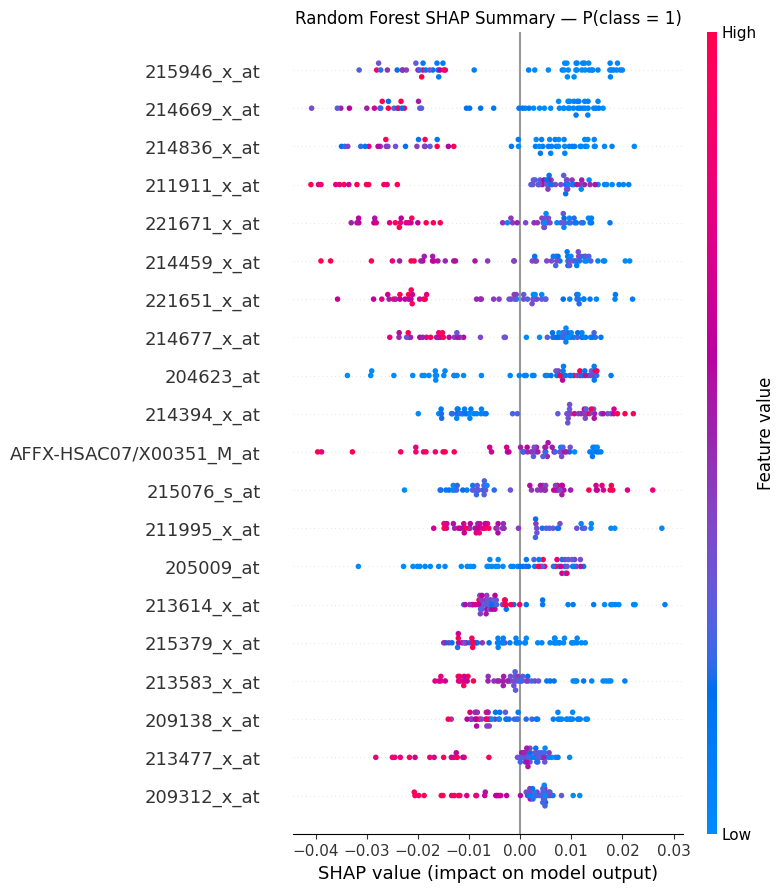

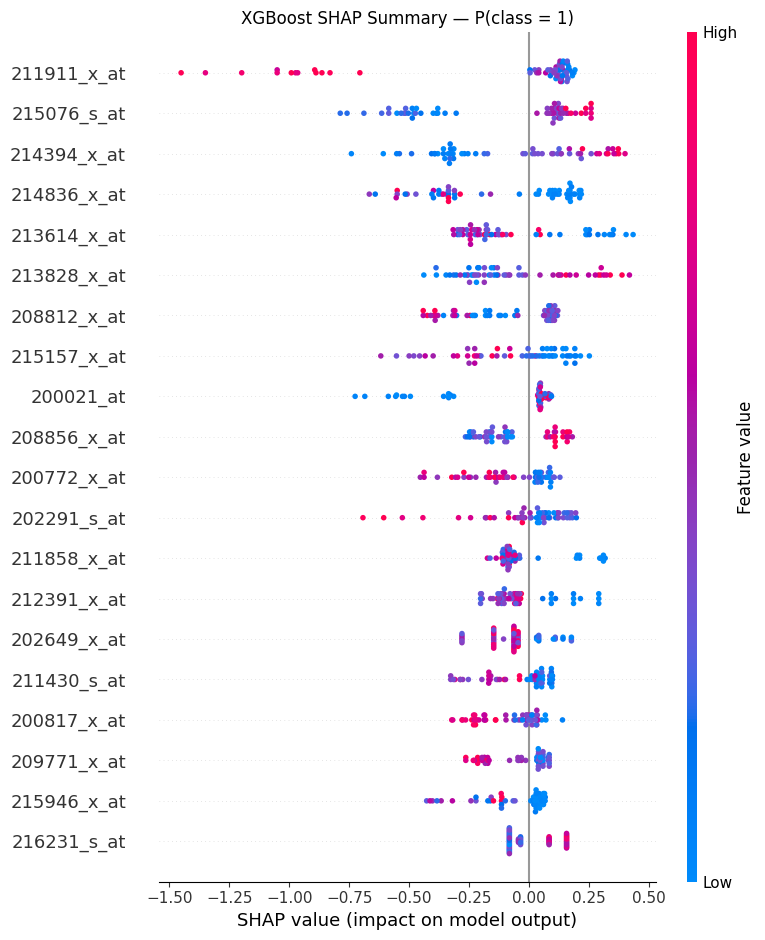

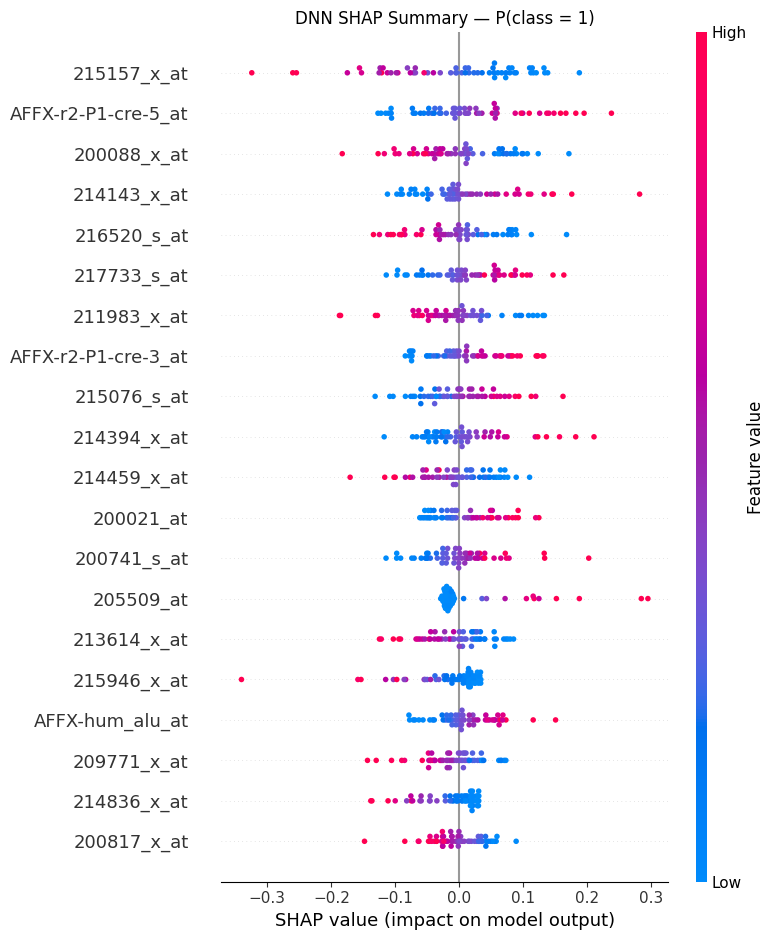

In [5]:
# RF

shap.summary_plot(
    shap_vals_rf,           # SHAP values for RF     
    rf_df,             # DataFrame with feature names
    feature_names=feature_names,                            
    show=False                          
)
plt.title("Random Forest SHAP Summary — P(class = 1)")
ax = plt.gca()                          
plt.tight_layout(rect=[0,0,1,0.95])                         
plt.show()

# XGB
shap.summary_plot(
    shap_vals_xgb,          # SHAP values for XGB
    X_test_xgb,         # DataFrame with feature names
    feature_names=feature_names,                                           
    show=False                  
)
plt.title("XGBoost SHAP Summary — P(class = 1)")
plt.tight_layout()
plt.show()

# DNN
vals = shap_exp_dnn.values
shap.summary_plot(
        vals,           # SHAP values for DNN
        X_eval_df,      # DataFrame with feature names  
        show=False              
    )
plt.title("DNN SHAP Summary — P(class = 1)")
plt.tight_layout()
plt.show()